### 1. M-Map 생성

In [55]:
import math
import pandas as pd

csv_df = pd.read_csv("data/position_data (13).csv")
# mmap_df = pd.DataFrame()

mmap_df = csv_df[(csv_df['UncalMagX']!=9999.9)&(csv_df['UncalMagY']!=9999.9)&(csv_df['UncalMagZ']!=9999.9)].copy()

# mmap_df['X'] = csv_df['X']
mmap_df['Y'] = mmap_df['Y'] + 66
mmap_df['mag'] = csv_df.apply(lambda x: math.sqrt(x['UncalMagX']*x['UncalMagX'] + x['UncalMagY']*x['UncalMagY'] + x['UncalMagZ']*x['UncalMagZ']), axis=1 )

mmap_df = mmap_df[['X', 'Y', 'mag']]
mmap_df

,X,Y,mag
0,37,53,124.263189
1,36,53,128.972323
2,35,53,136.229879
3,34,53,140.980282
4,33,53,140.220897
...,...,...,...
2602,47,62,150.324017
2603,47,63,155.291275
2604,47,64,153.871937
2605,47,65,150.683775


### 2. M-Map 시각화

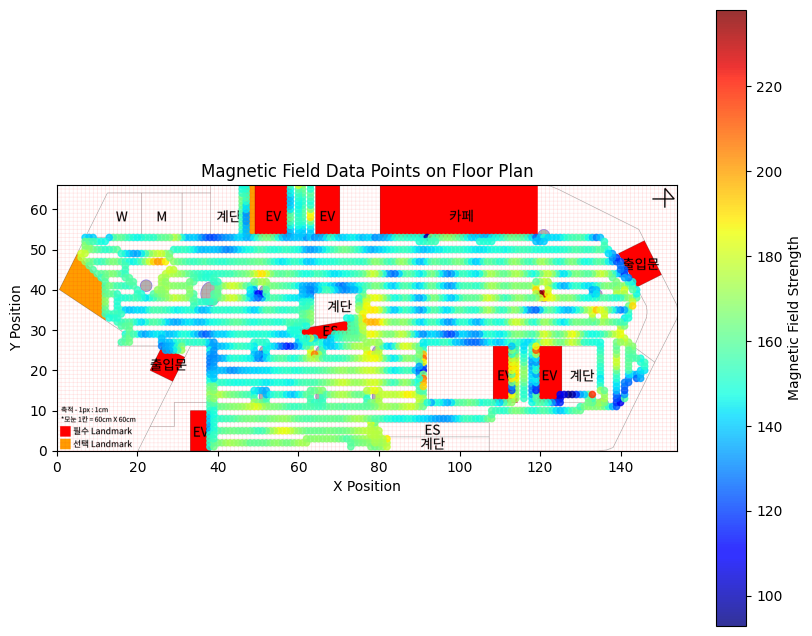

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize

# 1. 평면도 이미지 불러오기
floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
floor_plan = cv2.imread(floor_plan_path)
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환

# 2. 데이터 분리
x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# 3. 컬러 매핑 설정
norm = Normalize(vmin=np.min(mag), vmax=np.max(mag))  # 값의 범위 정규화
cmap = colormaps.get_cmap('jet')  # 컬러맵 설정
colors = cmap(norm(mag))  # 값을 컬러맵으로 변환

# 4. 평면도 위에 점만 표시
plt.figure(figsize=(10, 8))

# 평면도 이미지를 뒤집히지 않게 하기 위해 origin='upper'로 설정
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # extent=(x_min, x_max, y_min, y_max)

# 데이터 포인트에 색깔과 크기 적용
scatter = plt.scatter(x, y, c=mag, s=20, cmap=cmap, norm=norm, alpha=0.8)  # scatter의 cmap과 norm 설정

# 컬러바 추가
plt.colorbar(scatter, label='Magnetic Field Strength')  # scatter를 기반으로 컬러바 생성

plt.title('Magnetic Field Data Points on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


### 3. 보간된 M-Map

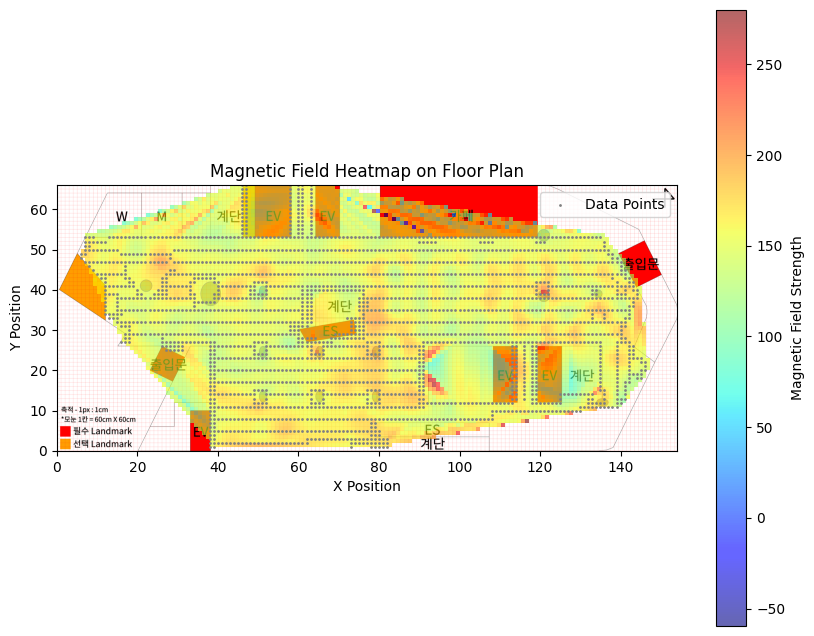

In [57]:
from scipy.interpolate import griddata

x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:154:1, 0:66:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')

mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})

# Heatmap 생성
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 154, 0, 66), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

### 4. Obstacle Mask 구하기

In [58]:
from scipy.ndimage import binary_fill_holes

# 장애물 데이터 (0: target area, 1: obstacle)
obstacle_mask = np.zeros((154,68), dtype=int) # Y축 방향은 임시로 맨 위와 맨 아래에 padding 추가

# 테두리를 1로 채우기
obstacle_mask[:,[0,-1]] = 1
obstacle_mask[[0,-1],:] = 1

# CSV 수집데이터에서 장애물 정보 가져오기
obstacle_df = csv_df[(csv_df['UncalMagX']==9999.9)&(csv_df['UncalMagY']==9999.9)&(csv_df['UncalMagZ']==9999.9)].copy()
obstacle_df['Y'] = obstacle_df['Y'] + 66

obstacle_mask[obstacle_df['X'],obstacle_df['Y']] = 1

# 외곽선만 있고 내부가 색칠되지 않은 영역 색칠하기
obstacle_mask[:46] = binary_fill_holes(obstacle_mask[:46]).astype(int)
obstacle_mask[46:] = binary_fill_holes(obstacle_mask[46:]).astype(int)

# Y축 방향 임시 padding 제거 (맨 위와 맨 아래)
obstacle_mask = obstacle_mask[:,1:-1]

print(obstacle_mask.shape)

# 파일로 저장하기
np.savetxt('data/obstacle_mask.txt', obstacle_mask, fmt='%d')
# obstacle_mask = np.loadtxt('data/obstacle_mask.txt', dtype=int) # 다시 불러오는 코드

(154, 66)


In [59]:
# position이 장애물인지 확인 방법: obstacle_mask[x좌표, y좌표]
obstacle_mask[112,25] # 예시 - (65,37)은 장애물이 맞다

np.int64(1)

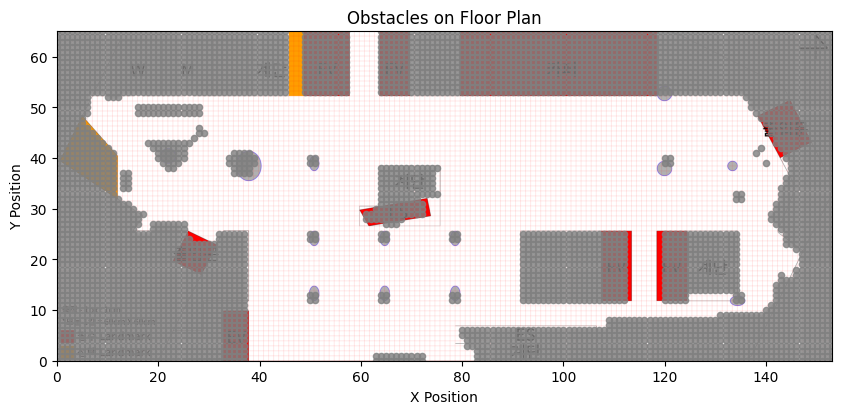

In [60]:
# obstacle_grid 시각화 (확인 용도!)

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# 평면도 이미지
floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
floor_plan = cv2.imread(floor_plan_path)
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환
plt.imshow(floor_plan, extent=(0, 153, 0, 65), origin='upper') # extent=(x_min, x_max, y_min, y_max)

# 데이터 포인트에 색깔과 크기 적용
plt.scatter(np.where(obstacle_mask==1)[0], np.where(obstacle_mask==1)[1], c='grey', s=20,  alpha=0.8)

plt.title('Obstacles on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


### 5. 보간하는 좌표 단위를 0.1로 설정 & 보간된 데이터에서 obstacle mask 해당 부분 제거

C:\Users\sage\AppData\Local\Temp\ipykernel_23084\2574838631.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


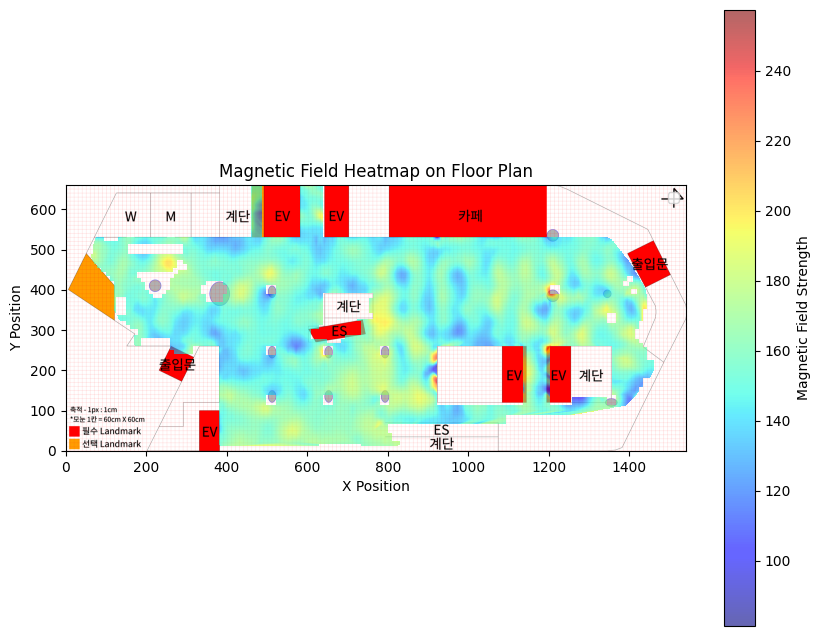

In [ ]:
from scipy.interpolate import griddata
from scipy.ndimage import zoom

x = mmap_df['X'].to_numpy() * 10
y = mmap_df['Y'].to_numpy() * 10
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:1540:1, 0:660:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')


# 보간된 데이터에서 obstacle mask 해당 부분 제거
obstacle_mask_zoom = zoom(obstacle_mask, zoom=10, order=0)
grid_z = np.where(obstacle_mask_zoom==1, np.nan, grid_z)

# DataFrame으로 변환
mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})
mmap_grid_df['X'] /= 10
mmap_grid_df['Y'] /= 10
mmap_grid_df = mmap_grid_df.fillna(9999.9)


# Heatmap 생성
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 1540, 0, 660), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 1540, 0, 660), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
# plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

In [ ]:
# csv 저장
mmap_grid_df.to_csv("data/M_map_version3.csv", index=False)
mmap_grid_df

,X,Y,mag
0,0.0,0.0,9999.9
1,0.0,0.1,9999.9
2,0.0,0.2,9999.9
3,0.0,0.3,9999.9
4,0.0,0.4,9999.9
...,...,...,...
1016395,153.9,65.5,9999.9
1016396,153.9,65.6,9999.9
1016397,153.9,65.7,9999.9
1016398,153.9,65.8,9999.9


In [65]:
# mmap_grid_df2 = pd.read_csv("data/M_map_version2.csv")

# temp_df = mmap_grid_df.merge(mmap_grid_df2, on = ['X','Y'])
# temp_df[temp_df['mag_x'] - temp_df['mag_y'] > 1]

### Calibrated Version

C:\Users\sage\AppData\Local\Temp\ipykernel_23084\521727718.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


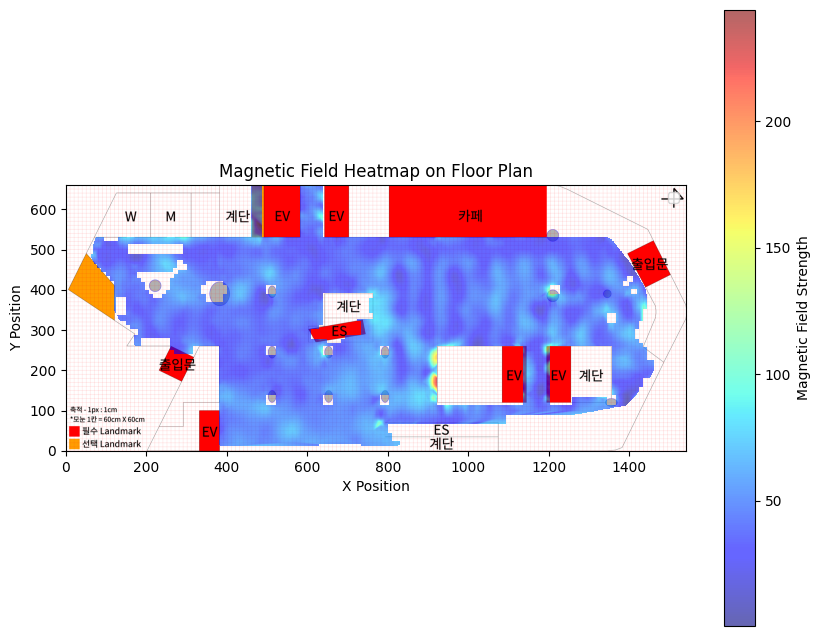

,X,Y,mag
0,0.0,0.0,9999.9
1,0.0,0.1,9999.9
2,0.0,0.2,9999.9
3,0.0,0.3,9999.9
4,0.0,0.4,9999.9
...,...,...,...
1016395,153.9,65.5,9999.9
1016396,153.9,65.6,9999.9
1016397,153.9,65.7,9999.9
1016398,153.9,65.8,9999.9


In [64]:
import math
import pandas as pd

csv_df = pd.read_csv("data/position_data (13).csv")
# mmap_df = pd.DataFrame()

mmap_df = csv_df[(csv_df['MagX']!=9999.9)&(csv_df['MagY']!=9999.9)&(csv_df['MagZ']!=9999.9)].copy()

# mmap_df['X'] = csv_df['X']
mmap_df['Y'] = mmap_df['Y'] + 66
mmap_df['mag'] = csv_df.apply(lambda x: math.sqrt(x['MagX']*x['MagX'] + x['MagY']*x['MagY'] + x['MagZ']*x['MagZ']), axis=1 )

mmap_df = mmap_df[['X', 'Y', 'mag']]


from scipy.interpolate import griddata
from scipy.ndimage import zoom

x = mmap_df['X'].to_numpy() * 10
y = mmap_df['Y'].to_numpy() * 10
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:1540:1, 0:660:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')



obstacle_mask_zoom = zoom(obstacle_mask, zoom=10, order=0)

grid_z = np.where(obstacle_mask_zoom==1, np.nan, grid_z)


mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})
mmap_grid_df['X'] /= 10
mmap_grid_df['Y'] /= 10
mmap_grid_df = mmap_grid_df.fillna(9999.9)


# Heatmap 생성
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 1540, 0, 660), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 1540, 0, 660), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
# plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

mmap_grid_df.to_csv("data/M_map_version3_cali.csv", index=False)
mmap_grid_df